# DataFrames and Series

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ElementsOfDataScience/blob/master/07_dataframes.ipynb) or
[click here to download it](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/07_dataframes.ipynb).

This chapter introduces Pandas, a Python library that provides functions for reading and writing data files, exploring and analyzing data, and generating visualizations.  And it provides two new types for working with data, `DataFrame` and `Series`.

We will use these tools to answer a data question: what is the average birth weight of babies in the United States?
This example will demonstrate important steps in almost any data science project:

1. Identifying data that can answer a question.

2. Obtaining the data and loading it in Python.

3. Checking the data and dealing with errors.

4. Selecting relevant subsets from the data.

5. Using histograms to visualize a distribution of values.

6. Using summary statistics to describe the data in a way that best answers the question.

7. Considering possible sources of error and limitations in our conclusions.

Let's start by getting the data.

## Reading the Data

We'll use data from the National Survey of Family Growth (NSFG), which is available from the National Center for Health Statistics at <https://www.cdc.gov/nchs/nsfg/index.htm>.

To download the data, you have to agree to the Data User's Agreement at <https://www.cdc.gov/nchs/data_access/ftp_dua.htm>.
You should read those terms carefully, but let me draw your attention to what I think is the most important one:

> Make no attempt to learn the identity of any person or establishment included in these data.

NSFG respondents provide honest answers to questions of the most personal nature with the expectation that their identities will not be revealed.
As ethical data scientists, we should respect their privacy and adhere to the terms of use.

Respondents to the NSFG provide general information about themselves, which is stored in the respondent file, and information about each time they have been pregnant, which is stored in the pregnancy file.

We will work with the pregnancy file, which contains one row for each pregnancy and one column for each of the 248 variables.
Each variable represents responses to a question on the NSFG questionnaire.

The data is stored in a fixed-width format, which means that every row is the same length and each variable spans a fixed range of characters (see <https://www.ibm.com/docs/en/baw/19.x?topic=formats-fixed-width-format>). For example, the first six characters in each row represent a variable called `CASEID`, which is a unique identifier for each respondent; the next two characters represent `PREGORDR`, which indicates whether a pregnancy is the respondent's first, second, etc.

To read this data, we need a **data dictionary**, which specifies the names of the variables and the range of characters where each variable appears. The data and the data dictionary are available in separate files.

In [45]:
dict_file = '2015_2017_FemPregSetup.dct'
data_file = '2015_2017_FemPregData.dat'

Once you have agreed to the terms, you can use the following cells to download the data.

In [46]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

In [47]:
download('https://ftp.cdc.gov/pub/health_statistics/nchs/' +
         'datasets/NSFG/stata/' + dict_file)

In [48]:
download('https://ftp.cdc.gov/pub/health_statistics/nchs/' +
         'datasets/NSFG/' + data_file)

Pandas can read data in most common formats, including CSV, Excel, and fixed-width format, but it cannot read the data dictionary, which is in Stata format.
For that, we'll use a Python library called `statadict`.

The following cell installs `statadict` if necessary.

In [49]:
try:
    from statadict import parse_stata_dict
except ImportError:
    !pip install statadict

From `statadict`, we'll import `parse_stata_dict`, which reads the data dictionary.

In [50]:
from statadict import parse_stata_dict

stata_dict = parse_stata_dict(dict_file)
stata_dict

The result is an object that contains

* `names`, which is a list of variable names, and

* `colspecs`, which is a list of tuples.

Each tuple in `colspecs` specifies the first and last column where a variable appears.

These values are exactly the arguments we need to use `read_fwf`, which is the Pandas function that reads a file in fixed-width format.

In [51]:
import pandas as pd

nsfg = pd.read_fwf(data_file, 
                   names=stata_dict.names, 
                   colspecs=stata_dict.colspecs)
type(nsfg)

pandas.core.frame.DataFrame

The result from `read_fwf()` is a `DataFrame`, which is the primary type Pandas uses to store data.
`DataFrame` has a method called `head()` that shows the first 5 rows:

In [52]:
nsfg.head()

,CASEID,PREGORDR,HOWPREG_N,HOWPREG_P,MOSCURRP,NOWPRGDK,PREGEND1,PREGEND2,HOWENDDK,NBRNALIV,...,SECU,SEST,CMINTVW,CMLSTYR,CMJAN3YR,CMJAN4YR,CMJAN5YR,QUARTER,PHASE,INTVWYEAR
0,70627,1,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,3,322,1394,1382,1357,1345,1333,18,1,2016
1,70627,2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,3,322,1394,1382,1357,1345,1333,18,1,2016
2,70627,3,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,3,322,1394,1382,1357,1345,1333,18,1,2016
3,70628,1,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,2,366,1409,1397,1369,1357,1345,23,1,2017
4,70628,2,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,2,366,1409,1397,1369,1357,1345,23,1,2017


In [53]:
# NOTE: For the printed version of the book, 
# I'm using iloc to show
# the first 5 rows and first 9 columns

In [54]:
nsfg.iloc[:5,:7]

,CASEID,PREGORDR,HOWPREG_N,HOWPREG_P,MOSCURRP,NOWPRGDK,PREGEND1
0,70627,1,NaN,NaN,NaN,NaN,6.0
1,70627,2,NaN,NaN,NaN,NaN,1.0
2,70627,3,NaN,NaN,NaN,NaN,6.0
3,70628,1,NaN,NaN,NaN,NaN,6.0
4,70628,2,NaN,NaN,NaN,NaN,6.0


The first two columns are is `CASEID` and `PREGORDR`, which I mentioned earlier.
The first three rows have the same `CASEID`, so this respondent reported three pregnancies; the values of `PREGORDR` indicate that they are the first, second, and third pregnancies, in that order.

We will learn more about the other variables as we go along.

In addition to methods like `head`, a `Dataframe` object has several **attributes**, which are variables associated with the object.
For example, `nsfg` has an attribute called `shape`, which is a tuple containing the number of rows and columns:

In [55]:
nsfg.shape

(9553, 248)

There are 9553 rows in this dataset, one for each pregnancy, and 248 columns, one for each variable.

`nsfg` also has an attribute called `columns`, which contains the column names:

In [56]:
nsfg.columns

Index(['CASEID', 'PREGORDR', 'HOWPREG_N', 'HOWPREG_P', 'MOSCURRP', 'NOWPRGDK',
       'PREGEND1', 'PREGEND2', 'HOWENDDK', 'NBRNALIV',
       ...
       'SECU', 'SEST', 'CMINTVW', 'CMLSTYR', 'CMJAN3YR', 'CMJAN4YR',
       'CMJAN5YR', 'QUARTER', 'PHASE', 'INTVWYEAR'],
      dtype='object', length=248)

The column names are stored in an `Index`, which is another Pandas type, similar to a list.

In [57]:
type(nsfg.columns)

pandas.core.indexes.base.Index

Based on the column names, you might be able to guess what some of the variables are, but in general you have to read the documentation.

When you work with datasets like the NSFG, it is important to read the documentation carefully. If you interpret a variable incorrectly, you can generate nonsense results and never realize it. So, before we start looking at data, let's get familiar with the NSFG codebook, which describes every variable.
You can download the codebook for this dataset from <https://github.com/AllenDowney/ElementsOfDataScience/raw/master/data/2015-2017_NSFG_FemPregFile_Codebook-508.pdf>.

If you search that document for "weigh at birth" you should find these variables related to birth weight.

* `BIRTHWGT_LB1`: Birthweight in Pounds - 1st baby from this pregnancy

* `BIRTHWGT_OZ1`: Birthweight in Ounces - 1st baby from this pregnancy

There are similar variables for a 2nd or 3rd baby, in the case of twins or triplets.
For now we will focus on the first baby from each pregnancy, and we will come back to the issue of multiple births.

## Series

In many ways a `DataFrame` is like a Python dictionary, where the column names are the keys and the columns are the values.  You can select a column from a `DataFrame` using the bracket operator, with a string as the key.

In [58]:
pounds = nsfg['BIRTHWGT_LB1']
type(pounds)

pandas.core.series.Series

The result is a `Series`, which is a Pandas type that represents a single column of data.
In this case the `Series` contains the birth weight, in pounds, for each live birth.

`head` shows the first five values in the `Series`, the name of the `Series`, and the data type:

In [59]:
pounds.head()

0    7.0
1    NaN
2    9.0
3    6.0
4    7.0
Name: BIRTHWGT_LB1, dtype: float64

One of the values is `NaN`, which stands for "Not a Number".
`NaN` is a special value used to indicate invalid or missing data.
In this example, the pregnancy did not end in live birth, so birth weight is inapplicable.

**Exercise:**  The variable `BIRTHWGT_OZ1` contains the ounces part of birth weight.

Select the column `'BIRTHWGT_OZ1'` from the `nsfg` `DataFrame` and assign it to a new variable called `ounces`.  Then display the first 5 elements of `ounces`.

In [60]:
ounces = nsfg['BIRTHWGT_OZ1']
ounces.head()

0    8.0
1    NaN
2    2.0
3    9.0
4    0.0
Name: BIRTHWGT_OZ1, dtype: float64

**Exercise:** The Pandas types we have seen so far are `DataFrame`, `Index`, and `Series`.  You can find the documentation of these types at:

* `DataFrame`: <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html>

* `Index`: <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.html>

* `Series`: <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html>

This documentation can be overwhelming; I don't recommend trying to read it all now.  But you might want to skim it so you know where to look later.

## Validation

At this point we have identified the columns we need to answer the question and assigned them to variables named `pounds` and `ounces`.

In [61]:
pounds = nsfg['BIRTHWGT_LB1']
ounces = nsfg['BIRTHWGT_OZ1']

Before we do anything with this data, we have to validate it.  One part of validation is confirming that we are interpreting the data correctly.

We can use the `value_counts` method to see what values appear in `pounds` and how many times each value appears.

In [62]:
pounds.value_counts()

BIRTHWGT_LB1
7.0     2268
6.0     1644
8.0     1287
5.0      570
9.0      396
4.0      179
99.0      89
10.0      82
3.0       76
2.0       46
1.0       28
11.0      17
0.0        2
12.0       2
98.0       2
13.0       1
14.0       1
Name: count, dtype: int64

By default, the results are sorted with the most frequent value first, but we can use `sort_index` to sort them by value instead, with the lightest babies first and heaviest babies last.

In [63]:
pounds.value_counts().sort_index()

BIRTHWGT_LB1
0.0        2
1.0       28
2.0       46
3.0       76
4.0      179
5.0      570
6.0     1644
7.0     2268
8.0     1287
9.0      396
10.0      82
11.0      17
12.0       2
13.0       1
14.0       1
98.0       2
99.0      89
Name: count, dtype: int64

In [64]:
sum(pounds.isnull())

2863

As we'd expect, the most frequent values are 6-8 pounds, but there are some very light babies, a few very heavy babies, and two special values, 98, and 99.  According to the codebook, these values indicate that the respondent declined to answer the question (98) or did not know (99).

We can validate the results by comparing them to the codebook, which lists the values and their frequencies.


| value | label          | Total |
|-------|----------------|-------|
| .     | INAPPLICABLE   | 2863 |
| 0-5   | UNDER 6 POUNDS | 901 |
| 6     | 6 POUNDS       | 1644 |
| 7     | 7 POUNDS       | 2268 |
| 8     | 8 POUNDS       | 1287 |
| 9-95  | 9 POUNDS OR MORE | 499 |
| 98    | Refused          | 2 |
| 99    | Don't know       | 89 |
|       | Total            | 9553 |


The results from `value_counts` agree with the codebook, so we have some confidence that we are reading and interpreting the data correctly.

**Exercise:** In the `nsfg` `DataFrame`, the column `'OUTCOME'` encodes the outcome of each pregnancy as shown below:

| Value | Meaning |
|---|---|
| 1  | Live birth |
| 2  | Induced abortion |
| 3  | Stillbirth | 
| 4  | Miscarriage |
| 5  | Ectopic pregnancy |
| 6  | Current pregnancy |

Use `value_counts` to display the values in this column and how many times each value appears.  Are the results consistent with the codebook?

In [65]:
nsfg['OUTCOME'].value_counts().sort_index()

OUTCOME
1    6693
2     901
3     120
4    1515
5     123
6     201
Name: count, dtype: int64

## Summary Statistics

Another way to validate the data is with `describe`, which computes statistics that summarize the data, like the mean, standard deviation, minimum, and maximum.

Here are the results for `pounds`.  

In [66]:
pounds.describe()

count    6690.000000
mean        8.008819
std        10.771360
min         0.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        99.000000
Name: BIRTHWGT_LB1, dtype: float64

`count` is the number of values, not including `NaN`.
For this variable, there are 6690 value that are not `NaN`.

`mean` and `std` are the mean and standard deviation.
`min` and `max` are the minimum and maximum values, and in between are the 25th, 50th, and 75th percentiles.  The 50th percentile is the median.

The mean is about `8.05`, but that doesn't mean much because it includes the special values 98 and 99.  Before we can really compute the mean, we have to replace those values with `NaN` to identify them as missing data.

The `replace()` method does what we want:

In [67]:
import numpy as np

pounds_clean = pounds.replace([98, 99], np.nan)

`replace` takes a list of the values we want to replace and the value we want to replace them with.  `np.nan` means we are getting the special value `NaN` from the NumPy library, which is imported as `np`.

The result from `replace()` is a new `Series`, which I assign to `pounds_clean`.
If we run `describe` again, we see that `count` is smaller now because it includes only the valid values.

In [68]:
pounds_clean.describe()

count    6599.000000
mean        6.754357
std         1.383268
min         0.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        14.000000
Name: BIRTHWGT_LB1, dtype: float64

The mean of the new `Series` is about 6.7 pounds.
Remember that the mean of the original `Series` was more than 8 pounds.
It makes a big difference when you remove a few 99-pound babies!

**Exercise:** Use `describe` to summarize `ounces`.  
Then use `replace` to replace the special values 98 and 99 with NaN, and assign the result to `ounces_clean`.
Run `describe` again.  How much does this cleaning affect the results?

In [69]:
ounces.describe()

count    6601.000000
mean        7.642327
std         9.907332
min         0.000000
25%         3.000000
50%         7.000000
75%        11.000000
max        99.000000
Name: BIRTHWGT_OZ1, dtype: float64

In [70]:
ounces_clean = ounces.replace(99, np.nan)

In [71]:
ounces_clean.describe()

count    6542.000000
mean        6.818404
std         4.804005
min         0.000000
25%         3.000000
50%         7.000000
75%        11.000000
max        98.000000
Name: BIRTHWGT_OZ1, dtype: float64

## Series Arithmetic

Now we want to combine `pounds` and `ounces` into a single `Series` that contains total birth weight.
Arithmetic operators work with `Series` objects; so, for example, to convert `pounds` to ounces, we could write

`pounds * 16`

Then we could add in `ounces` like this

`pounds * 16 + ounces`

**Exercise:** Use `pounds_clean` and `ounces_clean` to compute the total birth weight expressed in kilograms (there are roughly 2.2 pounds per kilogram).  What is the mean birth weight in kilograms?

In [72]:
(((pounds * 16) + ounces) / 16) / 2.2

0       3.409091
1            NaN
2       4.147727
3       2.982955
4       3.181818
          ...   
9548    3.238636
9549         NaN
9550    3.977273
9551    3.096591
9552         NaN
Length: 9553, dtype: float64

**Exercise:** For each pregnancy in the NSFG dataset, the variable `'AGECON'` encodes the respondent's age at conception, and `'AGEPREG'` the respondent's age at the end of the pregnancy.

- Read the documentation of these variables.  Are there any special values we have to deal with?

- Select `'AGECON'` and `'AGEPREG'` and assign them to variables named `agecon` and `agepreg`.

- Compute the difference, which is an estimate of the duration of the pregnancy.

- Use `.describe()` to compute the mean duration and other summary statistics.

Based on the results, it seems like this might not be a good way to estimate the duration of pregnancy. Why not?

In [73]:
agecon = nsfg['AGECON']
agepreg = nsfg['AGEPREG']

In [74]:
durations = agepreg - agecon
durations.describe()

count    9352.000000
mean        0.554855
std         0.497008
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64

## Histograms

Let's get back to the original question: what is the average birth weight for babies in the U.S.?  
As an answer we *could* take the results from the previous section and compute the mean:

In [75]:
pounds_clean = pounds.replace([98, 99], np.nan)
ounces_clean = ounces.replace([98, 99], np.nan)

birth_weight = pounds_clean + ounces_clean / 16
birth_weight.mean()

7.180217889908257

But it is risky to compute a summary statistic, like the mean, before we look at the whole distribution of values.

A **distribution** is a set of possible values and their frequencies.  One way to visualize a distribution is a **histogram**, which shows values on the `x` axis and their frequencies on the `y` axis.

`Series` provides a `hist` method that makes histograms.
And we can use Matplotlib to label the axes.

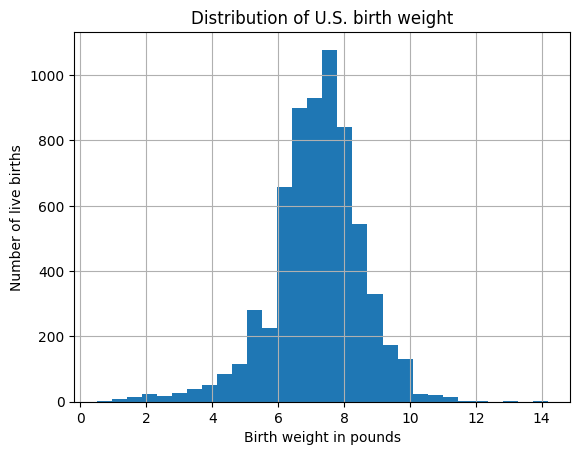

In [77]:
import matplotlib.pyplot as plt

birth_weight.hist(bins=30)
plt.xlabel('Birth weight in pounds')
plt.ylabel('Number of live births')
plt.title('Distribution of U.S. birth weight');

The keyword argument, `bins`, tells `hist` to divide the range of weights into 30 intervals, called **bins**, and count how many values fall in each bin.
The `x` axis is birth weight in pounds; the `y` axis is the number of births in each bin.

The distribution looks a little like a bell curve, but the tail is longer on the left than on the right; that is, there are more light babies than heavy babies.
That makes sense, because the distribution includes some babies that were born preterm.  

**Exercise:** `hist` takes keyword arguments that specify the type and appearance of the histogram.  Find the documentation of `hist` and see if you can figure out how to plot the histogram as an unfilled line against a background with no grid lines.

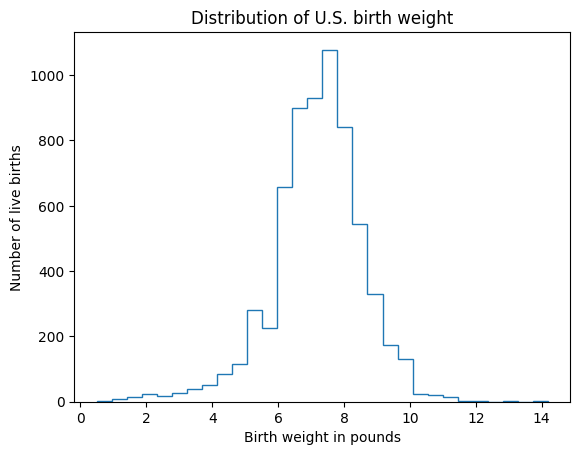

In [85]:
birth_weight.hist(bins=30, grid=False, histtype='step')
plt.xlabel('Birth weight in pounds')
plt.ylabel('Number of live births')
plt.title('Distribution of U.S. birth weight');

**Exercise:** As we saw in a previous exercise, the NSFG dataset includes a column called `AGECON` that records age at conception for each pregnancy. 

- Select this column from the `DataFrame` and plot the histogram of the values with 20 bins.

- Label the `x` and `y` axes appropriately.

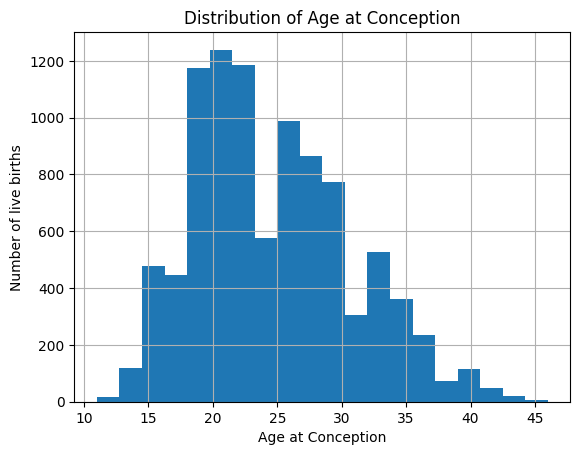

In [87]:
agecon = nsfg['AGECON']
agecon.hist(bins=20)
plt.xlabel('Age at Conception')
plt.ylabel('Number of live births')
plt.title('Distribution of Age at Conception');

## Boolean Series

We have seen that the distribution of birth weights is **skewed** to the left; that is, there are more light babies than heavy ones and they are farther from the mean.
That's because preterm babies tend to be lighter.  The most common duration for pregnancy is 39 weeks, which is "full term"; "preterm" is usually defined to be less than 37 weeks.

To see which babies are preterm, we can use `PRGLNGTH`, which records pregnancy length in weeks and compute it to `37`.

In [88]:
preterm = (nsfg['PRGLNGTH'] < 37)
preterm.dtype

dtype('bool')

When you compare a `Series` to a value, the result is a Boolean `Series`; that is, a `Series` where each element is a Boolean value, `True` or `False`.  In this case, it's `True` for each preterm baby and `False` otherwise.  We can use `head` to see the first 5 elements.

In [89]:
preterm.head()

0    False
1     True
2    False
3    False
4    False
Name: PRGLNGTH, dtype: bool

If you compute the sum of a Boolean `Series`, it treats `True` as 1 and `False` as 0, so the sum is the number of `True` values, which is the number of preterm babies.

In [90]:
preterm.sum()

3675

If you compute the mean of a Boolean `Series`, you get the *fraction* of `True` values.
In this case, it's about 0.38; that is, about 38% of the pregnancies are less than 37 weeks.

In [91]:
preterm.mean()

0.38469590704490736

However, this result might be misleading because it includes all pregnancy outcomes, not just live births.
We can create another Boolean `Series` to indicate which pregnancies ended in live birth:

In [92]:
live = (nsfg['OUTCOME'] == 1)
live.mean()

0.7006176070344394

Now we can use the operator `&`, which represents the logical AND operation, to identify pregnancies where the outcome is a live birth and preterm: 

In [93]:
live_preterm = (live & preterm)
live_preterm.mean()

0.08929132209777034

About 9% of all pregnancies resulted in a preterm live birth.

**Exercise:** Of all live births, what fraction are preterm?

In [95]:
sum(live_preterm) / sum(live)

0.12744658598535782

The other common logical operators are:
    
* `|`, which represents the logical OR operation; for example `live | preterm` is true if either `live` is true, or `preterm` is true, or both.

* `~`, which represents the logical NOT operation; for example `~live` is true if `live` is false or `NaN`.

The logical operators treat `NaN` the same as `False`, so you should be careful about using the NOT operator with a Series that contains `NaN` values.
For example, `~preterm` would include not just full term pregnancies, but also pregnancies with unknown length.

**Exercise:** Of all pregnancies, what fraction are full term, that is, 37 weeks or more?
Of all live births, what fraction are full term?

In [102]:
full_term = (nsfg['PRGLNGTH'] >= 37)
full_term.mean()

0.6153040929550927

In [104]:
sum(full_term) / sum(live)

0.878230987598984

In [109]:
full_term_and_live = (nsfg['PRGLNGTH'] >= 37) & (nsfg['OUTCOME'] == 1)

In [110]:
sum(full_term_and_live) / sum(live)

0.8725534140146421

## Filtering Data

We can use a Boolean `Series` as a filter; that is, we can select only rows that satisfy a condition or meet some criterion.
For example, we can use `preterm` and the bracket operator to select values from `birth_weight`, so `preterm_weight` gets birth weights for preterm babies. 

In [ ]:
preterm_weight = birth_weight[preterm]
preterm_weight.mean()

To select full-term babies, we can create a Boolean `Series` like this:

In [ ]:
fullterm = (nsfg['PRGLNGTH'] >= 37)

And use it to select birth weights for full term babies:

In [ ]:
full_term_weight = birth_weight[fullterm]
full_term_weight.mean()

As expected, full term babies are heavier, on average, than preterm babies.
To be more explicit, we could also limit the results to live births, like this:

In [ ]:
full_term_weight = birth_weight[live & fullterm]
full_term_weight.mean()

But in this case we get the same result because `birth_weight` is only valid for live births.

**Exercise:** Let's see if there is a difference in weight between single births and multiple births (twins, triplets, etc.).
The variable `NBRNALIV` represents the number of babies born alive from a single pregnancy.

In [ ]:
nbrnaliv = nsfg['NBRNALIV']
nbrnaliv.value_counts()

Use `nbrnaliv` and `live` to create a Boolean series called `multiple` that is true for multiple live births.
Of all live births, what fraction are multiple births?

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

**Exercise:** Make a Boolean series called `single` that is true for single live births.
Of all single births, what fraction are preterm?
Of all multiple births, what fraction are preterm?

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

**Exercise:** What is the average birth weight for live, single, full-term births?

In [ ]:
# Solution goes here

## Weighted Means

We are almost done, but there's one more problem we have to solve: oversampling.

The NSFG is not exactly representative of the U.S. population.  By design, some groups are more likely to appear in the sample than others; that is, they are **oversampled**.  Oversampling helps to ensure that you have enough people in every subgroup to get reliable statistics, but it makes data analysis a little more complicated.

Each pregnancy in the dataset has a **sampling weight** that indicates how many pregnancies it represents.  In `nsfg`, the sampling weight is stored in a column named `wgt2015_2017`.
Here's what it looks like.

In [ ]:
sampling_weight = nsfg['WGT2015_2017']
sampling_weight.describe()

The median value (50th percentile) in this column is about 7292, which means that a pregnancy with that weight represents 7292 total pregnancies in the population.
But the range of values is wide, so some rows represent many more pregnancies than others.

To take these weights into account, we can compute a **weighted mean**.  Here are the steps:

1. Multiply the birth weights for each pregnancy by the sampling weights and add up the products.

2. Add up the sampling weights.

3. Divide the first sum by the second.

To do this correctly, we have to be careful with missing data.
To help with that, we'll use two `Series` methods, `isna` and `notna`.

`isna` returns a Boolean `Series` that is `True` where the corresponding value is `NaN`.

In [ ]:
missing = birth_weight.isna()
missing.sum()

In `birth_weight` there are 3013 missing values (mostly for pregnancies that did not end in live birth).

`notna` returns a Boolean `Series` that is `True` where the corresponding value is *not* `NaN`.

In [ ]:
valid = birth_weight.notna()
valid.sum()

We can combine `valid` with the other Boolean `Series` we have computed to identify single, full term, live births with valid birth weights.

In [ ]:
single = (nbrnaliv == 1)
selected = valid & live & single & fullterm
selected.sum()

You can finish off this computation as an exercise.

**Exercise:** Use `selected`, `birth_weight`, and `sampling_weight` to compute the weighted mean of birth weight for live, single, full term births.

You should find that the weighted mean is a little higher than the unweighted mean we computed in the previous section.  That's because the groups that are oversampled in the NSFG tend to have lighter babies, on average.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

## Summary

This chapter poses what seems like a simple question: what is the average birth weight of babies in the United States?

To answer it, we found an appropriate dataset and read the files.  Then we validated the data and dealt with special values, missing data, and errors.
To explore the data, we used `value_counts`, `hist`, `describe`, and other Pandas methods.
And to select relevant data, we used Boolean `Series`.

Along the way, we had to think more about the question.  What do we mean by "average", and which babies should we include?  Should we include all live births or exclude preterm babies or multiple births?

And we had to think about the sampling process.  By design, the NSFG respondents are not representative of the U.S. population, but we can use sampling weights to correct for this effect.

Even a simple question can be a challenging data science project.

*Elements of Data Science*

Copyright 2021 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)